In [1]:
import matplotlib.pyplot as plt

from turtle import forward
import numpy as np
import pandas as pd
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image

from torch.utils.data import Dataset, DataLoader


import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
os.getcwd()



'/home/not7/src/Vladimir-Ershov.github.io/projects/MLRecap/torch'

In [2]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

True
NVIDIA GeForce RTX 3060
Using device: cuda


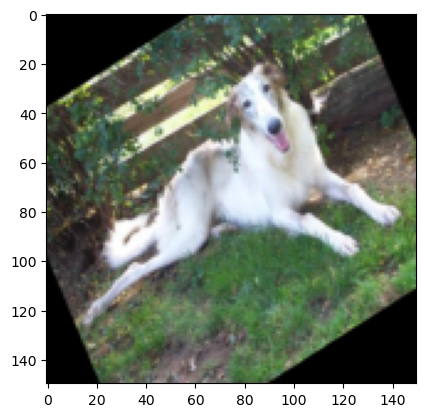

In [83]:
data_path = "../data/dogy/"
sample = '../data/dogy/train/borzoi/borzoi_19.jpg'

img = Image.open(sample)
img.size

preproc = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.Resize((150, 150)),    
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.3]), # x.mean(), x.std() (tensor(0.5055), tensor(0.2883))
])

img2 = preproc(img)
# img2
def imshow(img):
    img = img * 0.3 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# plt.imshow(np.transpose(img2, (1, 2, 0)))
# plt.show()
imshow(img2)

In [86]:
from random import shuffle
import torchvision
from torch.utils.data import DataLoader, random_split

batch_size =64
train_data = torchvision.datasets.ImageFolder(root=data_path + 'train/', transform=preproc)
test_data = torchvision.datasets.ImageFolder(root=data_path + 'test/', transform=preproc)

len_test_data = len(test_data)
len_train_data = len(train_data)

print(f"{len_train_data}/{len_test_data}   split = {len_test_data/(len_test_data + len_train_data)}")

trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=8)
testloader = DataLoader(test_data, batch_size=batch_size, shuffle=False,num_workers=8)

# %%
available_breeds = ['affenpinscher', 'african', 'airedale', 'akita', 'appenzeller', 'australian', 'basenji', 'beagle', 'bluetick', 'borzoi', 'bouvier', 'boxer', 'brabancon', 'briard', 'buhund', 'bulldog', 'bullterrier', 'cattledog', 'chihuahua', 'chow', 'clumber', 'cockapoo', 'collie', 'coonhound', 'corgi', 'cotondetulear', 'dachshund', 'dalmatian', 'dane', 'deerhound', 'dhole', 'dingo', 'doberman', 'elkhound', 'entlebucher', 'eskimo', 'finnish', 'frise', 'germanshepherd', 'greyhound', 'groenendael', 'havanese', 'hound', 'husky', 'keeshond', 'kelpie', 'komondor', 'kuvasz', 'labradoodle', 'labrador', 'leonberg', 'lhasa', 'malamute', 'malinois', 'maltese', 'mastiff', 'mexicanhairless', 'mix', 'mountain', 'newfoundland', 'otterhound', 'ovcharka', 'papillon', 'pekinese', 'pembroke', 'pinscher', 'pitbull', 'pointer', 'pomeranian', 'poodle', 'pug', 'puggle', 'pyrenees', 'redbone', 'retriever', 'ridgeback', 'rottweiler', 'saluki', 'samoyed', 'schipperke', 'schnauzer', 'setter', 'sheepdog', 'shiba', 'shihtzu', 'spaniel', 'springer', 'stbernard', 'terrier', 'tervuren', 'vizsla', 'waterdog', 'weimaraner', 'whippet', 'wolfhound']
NUM_CLASSES = len(available_breeds)

# TODO: set up model class
class ImageMulticlassClassificationNet(nn.Module):
    def __init__(self, NUM_CLASSES, input_shape=(3,150,150)) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 6, 3), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        dummy = torch.zeros(1, *input_shape)
        with torch.no_grad():
            n_features = self.features(dummy).numel()

        self.classifier = nn.Sequential(
            nn.Linear(n_features, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, NUM_CLASSES),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

# input = torch.rand(1, 1, 50, 50) # BS, C, H, W
model = ImageMulticlassClassificationNet(NUM_CLASSES)
model.to(device)

total_params = 0
for name, param in model.named_parameters():
    numel = param.numel()
    print(f"{name}: {param.shape} | {numel} params")
    total_params += numel

print(f"\nTotal parameters: {total_params}")


9500/1900   split = 0.16666666666666666
features.0.weight: torch.Size([6, 3, 3, 3]) | 162 params
features.0.bias: torch.Size([6]) | 6 params
features.3.weight: torch.Size([16, 6, 3, 3]) | 864 params
features.3.bias: torch.Size([16]) | 16 params
classifier.0.weight: torch.Size([512, 20736]) | 10616832 params
classifier.0.bias: torch.Size([512]) | 512 params
classifier.2.weight: torch.Size([256, 512]) | 131072 params
classifier.2.bias: torch.Size([256]) | 256 params
classifier.4.weight: torch.Size([95, 256]) | 24320 params
classifier.4.bias: torch.Size([95]) | 95 params

Total parameters: 10774135


In [105]:
import torchvision.models as models
import torch.nn as nn

class ImageMulticlassClassificationNet2(nn.Module):
    def __init__(self, NUM_CLASSES):
        super().__init__()
        self.backbone = models.resnet18(pretrained=True)
        # Replace final classifier layer for 96 classes
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, NUM_CLASSES)
        self.classifier = nn.LogSoftmax(dim=1)
    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x
    
model2 = ImageMulticlassClassificationNet2(NUM_CLASSES)
model2.to(device)


/home/not7/src/Vladimir-Ershov.github.io/projects/MLRecap/.pixi/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/not7/src/Vladimir-Ershov.github.io/projects/MLRecap/.pixi/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/not7/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:02<00:00, 19.5MB/s]


ImageMulticlassClassificationNet2(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=

Epoch 0/10, Loss: 4.7605
Epoch 0/10, Loss: 4.6796
Epoch 0/10, Loss: 4.7188
Epoch 0/10, Loss: 4.6891
Epoch 0/10, Loss: 4.6309
Epoch 0/10, Loss: 4.6926
Epoch 0/10, Loss: 4.3816
Epoch 0/10, Loss: 4.4269
Epoch 0/10, Loss: 4.3745
Epoch 0/10, Loss: 4.4460
Epoch 0/10, Loss: 4.3308
Epoch 0/10, Loss: 4.4637
Epoch 0/10, Loss: 4.2609
Epoch 0/10, Loss: 4.1545
Epoch 0/10, Loss: 4.2813
Epoch 0/10, Loss: 4.0950
Epoch 0/10, Loss: 4.0681
Epoch 0/10, Loss: 4.1381
Epoch 0/10, Loss: 3.8868
Epoch 0/10, Loss: 3.8924
Epoch 0/10, Loss: 4.0155
Epoch 0/10, Loss: 3.7845
Epoch 0/10, Loss: 3.8239
Epoch 0/10, Loss: 3.9031
Epoch 0/10, Loss: 3.7605
Epoch 0/10, Loss: 3.5837
Epoch 0/10, Loss: 3.8724
Epoch 0/10, Loss: 3.4930
Epoch 0/10, Loss: 3.7138
Epoch 0/10, Loss: 3.8383
Epoch 0/10, Loss: 3.6875
Epoch 0/10, Loss: 3.5636
Epoch 0/10, Loss: 3.6776
Epoch 0/10, Loss: 3.5204
Epoch 0/10, Loss: 3.4315
Epoch 0/10, Loss: 3.5301
Epoch 0/10, Loss: 3.5480
Epoch 0/10, Loss: 3.6260
Epoch 0/10, Loss: 3.3930
Epoch 0/10, Loss: 3.2780


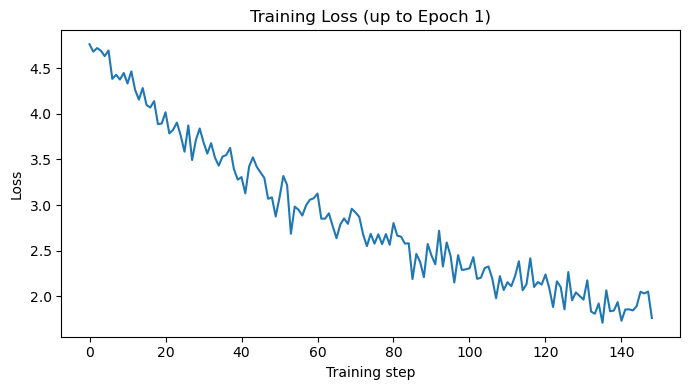

Epoch 1/10, Loss: 1.6685
Epoch 1/10, Loss: 1.5535
Epoch 1/10, Loss: 1.7702
Epoch 1/10, Loss: 1.5154
Epoch 1/10, Loss: 1.5856
Epoch 1/10, Loss: 1.7272
Epoch 1/10, Loss: 1.4833
Epoch 1/10, Loss: 1.7783
Epoch 1/10, Loss: 1.7863
Epoch 1/10, Loss: 1.4240
Epoch 1/10, Loss: 1.6830
Epoch 1/10, Loss: 1.4336
Epoch 1/10, Loss: 1.4517
Epoch 1/10, Loss: 1.5455
Epoch 1/10, Loss: 1.6296
Epoch 1/10, Loss: 1.6098
Epoch 1/10, Loss: 1.5756
Epoch 1/10, Loss: 1.6850
Epoch 1/10, Loss: 1.5791
Epoch 1/10, Loss: 1.6473
Epoch 1/10, Loss: 1.5478
Epoch 1/10, Loss: 1.4837
Epoch 1/10, Loss: 1.3004
Epoch 1/10, Loss: 1.5884
Epoch 1/10, Loss: 1.6245
Epoch 1/10, Loss: 1.6744
Epoch 1/10, Loss: 1.4915
Epoch 1/10, Loss: 1.5108
Epoch 1/10, Loss: 1.5611
Epoch 1/10, Loss: 1.4317
Epoch 1/10, Loss: 1.3385
Epoch 1/10, Loss: 1.4226
Epoch 1/10, Loss: 1.2379
Epoch 1/10, Loss: 1.5118
Epoch 1/10, Loss: 1.4845
Epoch 1/10, Loss: 1.7513
Epoch 1/10, Loss: 1.4811
Epoch 1/10, Loss: 1.4134
Epoch 1/10, Loss: 1.8316
Epoch 1/10, Loss: 1.5295


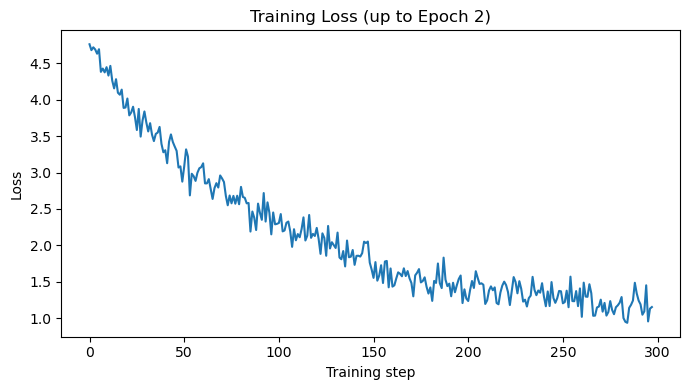

Epoch 2/10, Loss: 0.9680
Epoch 2/10, Loss: 1.0210
Epoch 2/10, Loss: 0.9919
Epoch 2/10, Loss: 0.9330
Epoch 2/10, Loss: 1.0642
Epoch 2/10, Loss: 0.9054
Epoch 2/10, Loss: 0.9667
Epoch 2/10, Loss: 1.1253
Epoch 2/10, Loss: 1.1383
Epoch 2/10, Loss: 0.9234
Epoch 2/10, Loss: 1.1496
Epoch 2/10, Loss: 0.8934
Epoch 2/10, Loss: 0.7382
Epoch 2/10, Loss: 0.9343
Epoch 2/10, Loss: 0.9138
Epoch 2/10, Loss: 1.0455
Epoch 2/10, Loss: 1.0007
Epoch 2/10, Loss: 0.9533
Epoch 2/10, Loss: 0.9492
Epoch 2/10, Loss: 0.9062
Epoch 2/10, Loss: 1.1183
Epoch 2/10, Loss: 1.2398
Epoch 2/10, Loss: 0.9445
Epoch 2/10, Loss: 0.8926
Epoch 2/10, Loss: 0.7645
Epoch 2/10, Loss: 0.8661
Epoch 2/10, Loss: 1.0483
Epoch 2/10, Loss: 0.8318
Epoch 2/10, Loss: 0.9220
Epoch 2/10, Loss: 0.9567
Epoch 2/10, Loss: 0.6786
Epoch 2/10, Loss: 1.0464
Epoch 2/10, Loss: 0.9288
Epoch 2/10, Loss: 0.9590
Epoch 2/10, Loss: 1.0252
Epoch 2/10, Loss: 0.8013
Epoch 2/10, Loss: 0.8591
Epoch 2/10, Loss: 0.8727
Epoch 2/10, Loss: 0.9941
Epoch 2/10, Loss: 0.8115


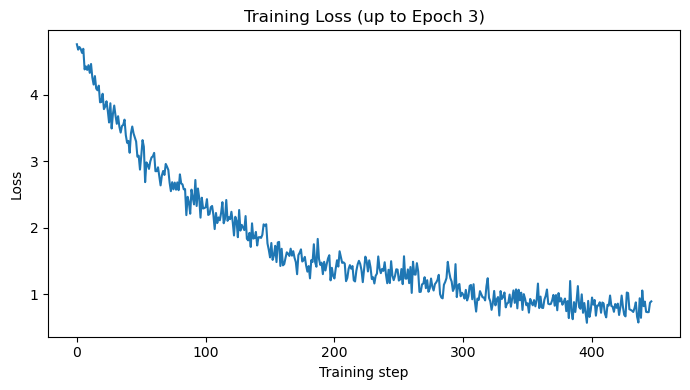

Epoch 3/10, Loss: 0.5703
Epoch 3/10, Loss: 0.5646
Epoch 3/10, Loss: 0.6202
Epoch 3/10, Loss: 0.6636
Epoch 3/10, Loss: 0.5477
Epoch 3/10, Loss: 0.6648
Epoch 3/10, Loss: 0.5842
Epoch 3/10, Loss: 0.5444
Epoch 3/10, Loss: 0.4675
Epoch 3/10, Loss: 0.7670
Epoch 3/10, Loss: 0.6851
Epoch 3/10, Loss: 0.8422
Epoch 3/10, Loss: 0.6183
Epoch 3/10, Loss: 0.5052
Epoch 3/10, Loss: 0.5529
Epoch 3/10, Loss: 0.4522
Epoch 3/10, Loss: 0.7255
Epoch 3/10, Loss: 0.6809
Epoch 3/10, Loss: 0.5392
Epoch 3/10, Loss: 0.7075
Epoch 3/10, Loss: 0.6717
Epoch 3/10, Loss: 0.8271
Epoch 3/10, Loss: 0.5379
Epoch 3/10, Loss: 0.6315
Epoch 3/10, Loss: 0.4405
Epoch 3/10, Loss: 0.6424
Epoch 3/10, Loss: 0.7120
Epoch 3/10, Loss: 0.7022
Epoch 3/10, Loss: 0.6222
Epoch 3/10, Loss: 0.6398
Epoch 3/10, Loss: 0.5604
Epoch 3/10, Loss: 0.5241
Epoch 3/10, Loss: 0.4991
Epoch 3/10, Loss: 0.5511
Epoch 3/10, Loss: 0.6549
Epoch 3/10, Loss: 0.6273
Epoch 3/10, Loss: 0.4970
Epoch 3/10, Loss: 0.5939
Epoch 3/10, Loss: 0.4196
Epoch 3/10, Loss: 0.5997


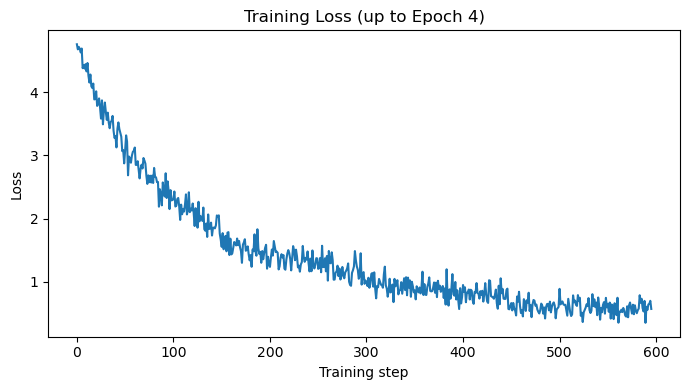

Epoch 4/10, Loss: 0.2678
Epoch 4/10, Loss: 0.3874
Epoch 4/10, Loss: 0.4296
Epoch 4/10, Loss: 0.3477
Epoch 4/10, Loss: 0.2883
Epoch 4/10, Loss: 0.3333
Epoch 4/10, Loss: 0.5477
Epoch 4/10, Loss: 0.2896
Epoch 4/10, Loss: 0.5025
Epoch 4/10, Loss: 0.4126
Epoch 4/10, Loss: 0.5888
Epoch 4/10, Loss: 0.3947
Epoch 4/10, Loss: 0.3524
Epoch 4/10, Loss: 0.4631
Epoch 4/10, Loss: 0.4461
Epoch 4/10, Loss: 0.4307
Epoch 4/10, Loss: 0.3286
Epoch 4/10, Loss: 0.3412
Epoch 4/10, Loss: 0.3630
Epoch 4/10, Loss: 0.4118
Epoch 4/10, Loss: 0.5016
Epoch 4/10, Loss: 0.3137
Epoch 4/10, Loss: 0.5448
Epoch 4/10, Loss: 0.6351
Epoch 4/10, Loss: 0.5147
Epoch 4/10, Loss: 0.4095
Epoch 4/10, Loss: 0.4875
Epoch 4/10, Loss: 0.4062
Epoch 4/10, Loss: 0.5766
Epoch 4/10, Loss: 0.4127
Epoch 4/10, Loss: 0.3558
Epoch 4/10, Loss: 0.3419
Epoch 4/10, Loss: 0.5017
Epoch 4/10, Loss: 0.2756
Epoch 4/10, Loss: 0.3750
Epoch 4/10, Loss: 0.5004
Epoch 4/10, Loss: 0.4375
Epoch 4/10, Loss: 0.6261
Epoch 4/10, Loss: 0.3460
Epoch 4/10, Loss: 0.4691


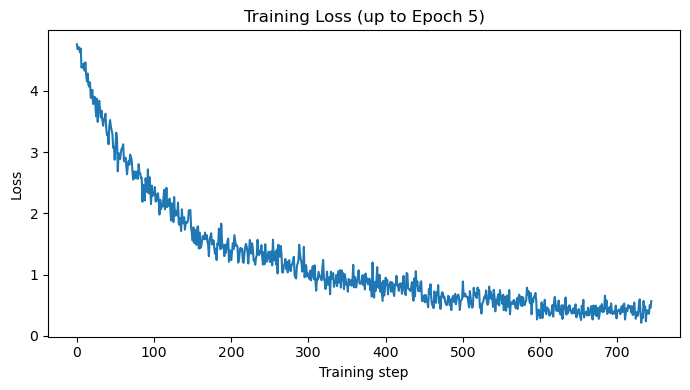

Epoch 5/10, Loss: 0.2225
Epoch 5/10, Loss: 0.2387
Epoch 5/10, Loss: 0.2993
Epoch 5/10, Loss: 0.2732
Epoch 5/10, Loss: 0.3046
Epoch 5/10, Loss: 0.3531
Epoch 5/10, Loss: 0.3103
Epoch 5/10, Loss: 0.3832
Epoch 5/10, Loss: 0.3316
Epoch 5/10, Loss: 0.3829
Epoch 5/10, Loss: 0.3255
Epoch 5/10, Loss: 0.3999
Epoch 5/10, Loss: 0.2454
Epoch 5/10, Loss: 0.2984
Epoch 5/10, Loss: 0.2935
Epoch 5/10, Loss: 0.4275
Epoch 5/10, Loss: 0.4257
Epoch 5/10, Loss: 0.3595
Epoch 5/10, Loss: 0.2174
Epoch 5/10, Loss: 0.2557
Epoch 5/10, Loss: 0.3769
Epoch 5/10, Loss: 0.2836
Epoch 5/10, Loss: 0.3026
Epoch 5/10, Loss: 0.1836
Epoch 5/10, Loss: 0.3406
Epoch 5/10, Loss: 0.2277
Epoch 5/10, Loss: 0.3456
Epoch 5/10, Loss: 0.1880
Epoch 5/10, Loss: 0.3151
Epoch 5/10, Loss: 0.3615
Epoch 5/10, Loss: 0.1451
Epoch 5/10, Loss: 0.2862
Epoch 5/10, Loss: 0.3339
Epoch 5/10, Loss: 0.2503
Epoch 5/10, Loss: 0.3448
Epoch 5/10, Loss: 0.4186
Epoch 5/10, Loss: 0.1686
Epoch 5/10, Loss: 0.3901
Epoch 5/10, Loss: 0.2953
Epoch 5/10, Loss: 0.2942


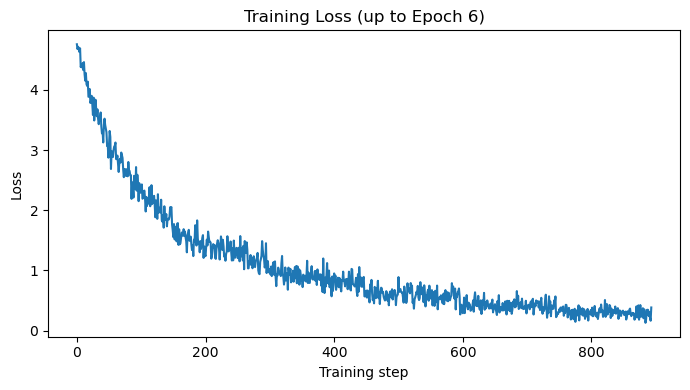

Epoch 6/10, Loss: 0.2077
Epoch 6/10, Loss: 0.1774
Epoch 6/10, Loss: 0.3550
Epoch 6/10, Loss: 0.2046
Epoch 6/10, Loss: 0.2282
Epoch 6/10, Loss: 0.2499
Epoch 6/10, Loss: 0.1171
Epoch 6/10, Loss: 0.2419
Epoch 6/10, Loss: 0.1525
Epoch 6/10, Loss: 0.3068
Epoch 6/10, Loss: 0.1799
Epoch 6/10, Loss: 0.2735
Epoch 6/10, Loss: 0.1855
Epoch 6/10, Loss: 0.2376
Epoch 6/10, Loss: 0.2318
Epoch 6/10, Loss: 0.1380
Epoch 6/10, Loss: 0.1292
Epoch 6/10, Loss: 0.3186
Epoch 6/10, Loss: 0.2482
Epoch 6/10, Loss: 0.2679
Epoch 6/10, Loss: 0.1986
Epoch 6/10, Loss: 0.3051
Epoch 6/10, Loss: 0.2697
Epoch 6/10, Loss: 0.2107
Epoch 6/10, Loss: 0.2137
Epoch 6/10, Loss: 0.1867
Epoch 6/10, Loss: 0.2110
Epoch 6/10, Loss: 0.1562
Epoch 6/10, Loss: 0.1763
Epoch 6/10, Loss: 0.1796
Epoch 6/10, Loss: 0.2283
Epoch 6/10, Loss: 0.1254
Epoch 6/10, Loss: 0.1100
Epoch 6/10, Loss: 0.1884
Epoch 6/10, Loss: 0.1972
Epoch 6/10, Loss: 0.2246
Epoch 6/10, Loss: 0.2123
Epoch 6/10, Loss: 0.2129
Epoch 6/10, Loss: 0.1892
Epoch 6/10, Loss: 0.2355


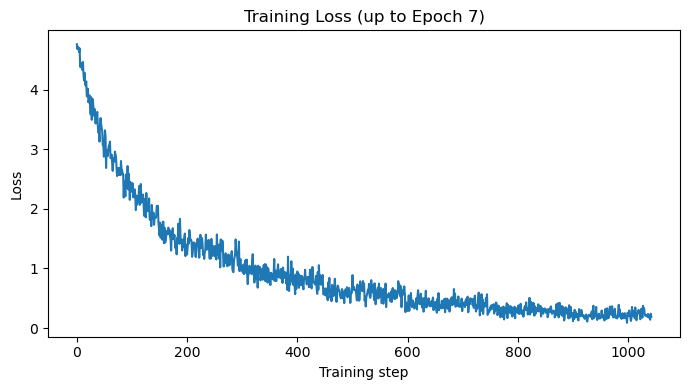

Epoch 7/10, Loss: 0.1346
Epoch 7/10, Loss: 0.1046
Epoch 7/10, Loss: 0.2400
Epoch 7/10, Loss: 0.2763
Epoch 7/10, Loss: 0.1519
Epoch 7/10, Loss: 0.0864
Epoch 7/10, Loss: 0.1437
Epoch 7/10, Loss: 0.1558
Epoch 7/10, Loss: 0.1273
Epoch 7/10, Loss: 0.1128
Epoch 7/10, Loss: 0.1286
Epoch 7/10, Loss: 0.2289
Epoch 7/10, Loss: 0.2585
Epoch 7/10, Loss: 0.1128
Epoch 7/10, Loss: 0.1407
Epoch 7/10, Loss: 0.1953
Epoch 7/10, Loss: 0.1626
Epoch 7/10, Loss: 0.2281
Epoch 7/10, Loss: 0.1783
Epoch 7/10, Loss: 0.1426
Epoch 7/10, Loss: 0.1281
Epoch 7/10, Loss: 0.2285
Epoch 7/10, Loss: 0.1747
Epoch 7/10, Loss: 0.2169
Epoch 7/10, Loss: 0.1835
Epoch 7/10, Loss: 0.1721
Epoch 7/10, Loss: 0.1576
Epoch 7/10, Loss: 0.1560
Epoch 7/10, Loss: 0.1024
Epoch 7/10, Loss: 0.2851
Epoch 7/10, Loss: 0.2365
Epoch 7/10, Loss: 0.0956
Epoch 7/10, Loss: 0.1168
Epoch 7/10, Loss: 0.1789
Epoch 7/10, Loss: 0.1490
Epoch 7/10, Loss: 0.1863
Epoch 7/10, Loss: 0.3441
Epoch 7/10, Loss: 0.1259
Epoch 7/10, Loss: 0.1458
Epoch 7/10, Loss: 0.1899


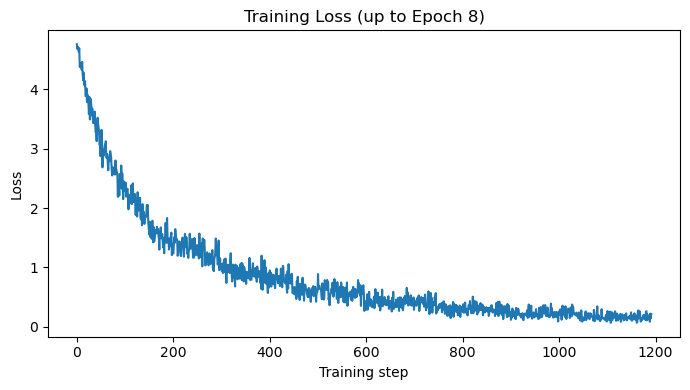

Epoch 8/10, Loss: 0.1358
Epoch 8/10, Loss: 0.1052
Epoch 8/10, Loss: 0.0671
Epoch 8/10, Loss: 0.1876
Epoch 8/10, Loss: 0.1100
Epoch 8/10, Loss: 0.1131
Epoch 8/10, Loss: 0.0866
Epoch 8/10, Loss: 0.1386
Epoch 8/10, Loss: 0.0844
Epoch 8/10, Loss: 0.0965
Epoch 8/10, Loss: 0.0950
Epoch 8/10, Loss: 0.0628
Epoch 8/10, Loss: 0.1066
Epoch 8/10, Loss: 0.0851
Epoch 8/10, Loss: 0.0965
Epoch 8/10, Loss: 0.1375
Epoch 8/10, Loss: 0.0880
Epoch 8/10, Loss: 0.0909
Epoch 8/10, Loss: 0.1442
Epoch 8/10, Loss: 0.1117
Epoch 8/10, Loss: 0.0931
Epoch 8/10, Loss: 0.1089
Epoch 8/10, Loss: 0.1249
Epoch 8/10, Loss: 0.2461
Epoch 8/10, Loss: 0.2172
Epoch 8/10, Loss: 0.1672
Epoch 8/10, Loss: 0.0832
Epoch 8/10, Loss: 0.0864
Epoch 8/10, Loss: 0.0989
Epoch 8/10, Loss: 0.1171
Epoch 8/10, Loss: 0.1355
Epoch 8/10, Loss: 0.1013
Epoch 8/10, Loss: 0.1488
Epoch 8/10, Loss: 0.0847
Epoch 8/10, Loss: 0.2116
Epoch 8/10, Loss: 0.0629
Epoch 8/10, Loss: 0.0883
Epoch 8/10, Loss: 0.1810
Epoch 8/10, Loss: 0.1182
Epoch 8/10, Loss: 0.1220


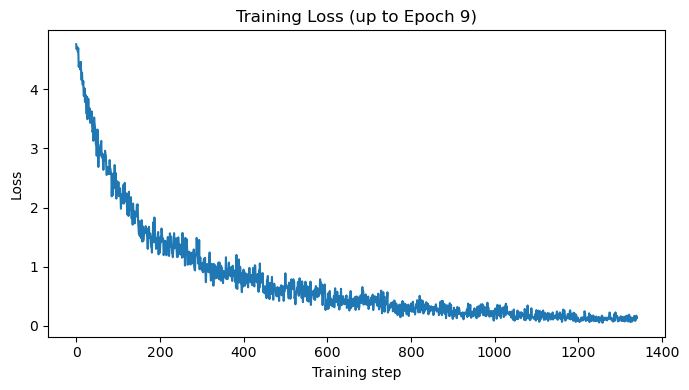

Epoch 9/10, Loss: 0.1428
Epoch 9/10, Loss: 0.0722
Epoch 9/10, Loss: 0.0639
Epoch 9/10, Loss: 0.0881
Epoch 9/10, Loss: 0.1414
Epoch 9/10, Loss: 0.0722
Epoch 9/10, Loss: 0.0862
Epoch 9/10, Loss: 0.0558
Epoch 9/10, Loss: 0.0865
Epoch 9/10, Loss: 0.0861
Epoch 9/10, Loss: 0.0657
Epoch 9/10, Loss: 0.0999
Epoch 9/10, Loss: 0.0533
Epoch 9/10, Loss: 0.0992
Epoch 9/10, Loss: 0.0479
Epoch 9/10, Loss: 0.1458
Epoch 9/10, Loss: 0.0679
Epoch 9/10, Loss: 0.1025
Epoch 9/10, Loss: 0.1108
Epoch 9/10, Loss: 0.0986
Epoch 9/10, Loss: 0.0374
Epoch 9/10, Loss: 0.0904
Epoch 9/10, Loss: 0.0963
Epoch 9/10, Loss: 0.0494
Epoch 9/10, Loss: 0.1241
Epoch 9/10, Loss: 0.0596
Epoch 9/10, Loss: 0.1669
Epoch 9/10, Loss: 0.0792
Epoch 9/10, Loss: 0.1194
Epoch 9/10, Loss: 0.0658
Epoch 9/10, Loss: 0.0794
Epoch 9/10, Loss: 0.0611
Epoch 9/10, Loss: 0.0520
Epoch 9/10, Loss: 0.1053
Epoch 9/10, Loss: 0.0972
Epoch 9/10, Loss: 0.1055
Epoch 9/10, Loss: 0.0870
Epoch 9/10, Loss: 0.0639
Epoch 9/10, Loss: 0.0665
Epoch 9/10, Loss: 0.1280


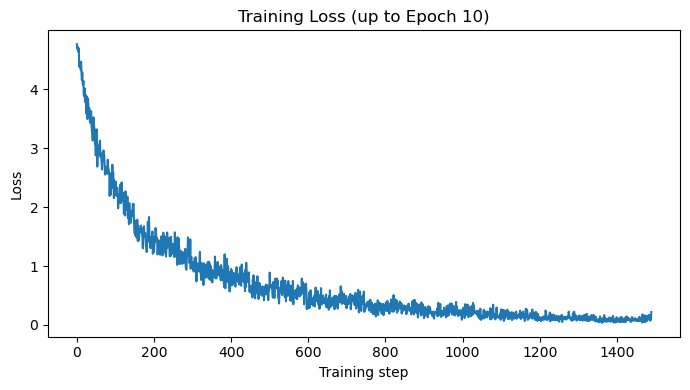

In [106]:
m = model2
loss = nn.NLLLoss()

optimiser = torch.optim.Adam(m.parameters(), lr=0.0001)

NUM_EPOCHS = 10
losses = []
for epoch in range(NUM_EPOCHS):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimiser.zero_grad()

        y_pred = m(inputs.to(device))
        loss_v = loss(y_pred, labels.to(device))

        loss_v.backward()
        losses.append(loss_v.item())

        optimiser.step()
    
        print(f'Epoch {epoch}/{NUM_EPOCHS}, Loss: {loss_v.item():.4f}')
    # Plot after each epoch, only the completed part
    plt.figure(figsize=(7, 4))
    sns.lineplot(x=range(len(losses)), y=losses)
    plt.title(f'Training Loss (up to Epoch {epoch+1})')
    plt.xlabel('Training step')
    plt.ylabel('Loss')
    plt.tight_layout()
    plt.show()    



In [107]:



y_test = []
y_test_hat = []

for i, data in enumerate(testloader, 0):
    inputs, y_test_temp = data
    with torch.no_grad():
        outputs = model(inputs.to(device))
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
    y_test.extend(y_test_temp.cpu().numpy())
    y_test_hat.extend(preds)

acc = accuracy_score(y_test, y_test_hat)
print(f'Accuracy: {acc*100:.2f} %')
cm = confusion_matrix(y_test, y_test_hat)
cm



Accuracy: 21.42 %


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 6, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0]])

In [108]:
import numpy as np

NUM_CLASSES = 96  # or len(train_data.classes)

# y_test: your list/array of ground-truth labels
np.random.seed(42)  # for reproducibility
y_random = np.random.randint(0, NUM_CLASSES, size=len(y_test))

from sklearn.metrics import accuracy_score, confusion_matrix

random_acc = accuracy_score(y_test, y_random)
print(f'Random classifier accuracy: {random_acc*100:.2f} %')

random_cm = confusion_matrix(y_test, y_random)
# random_cm can be visualized for further analysis

Random classifier accuracy: 1.42 %
